<a href="https://colab.research.google.com/github/anoushkarg12/1.4-Assignment-Capstone-Project/blob/main/Copy_of_FinalAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# step 0, importing any required libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
from sklearn.preprocessing  import StandardScaler
from sklearn.cluster        import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics        import silhouette_score
from scipy                  import stats
import warnings; warnings.filterwarnings("ignore")

RANDOM_STATE = 42


In [ ]:
# step 1, read the data
path = "spotify_tracks.csv" #Make sure this name is identical to the file
tracks_raw = pd.read_csv(path)

print("Shape:", tracks_raw.shape)
tracks_raw.head()

Shape: (114000, 21)


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [ ]:
# STEP 2 ▸ quick audit
# dataset info and count missing values
tracks_raw.info()
print(tracks_raw.isna().sum())

# drop rows with missing values
tracks = tracks_raw.dropna(subset=["artists", "track_name"]).reset_index(drop=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [ ]:
# step 3 slice numeric feature matrix
feature_cols = [
    "acousticness", "danceability", "energy", "instrumentalness",
    "liveness", "speechiness", "valence", "tempo",
    "loudness", "duration_ms", "popularity"
]

# copy of the feature matrix
X = tracks[feature_cols].copy()


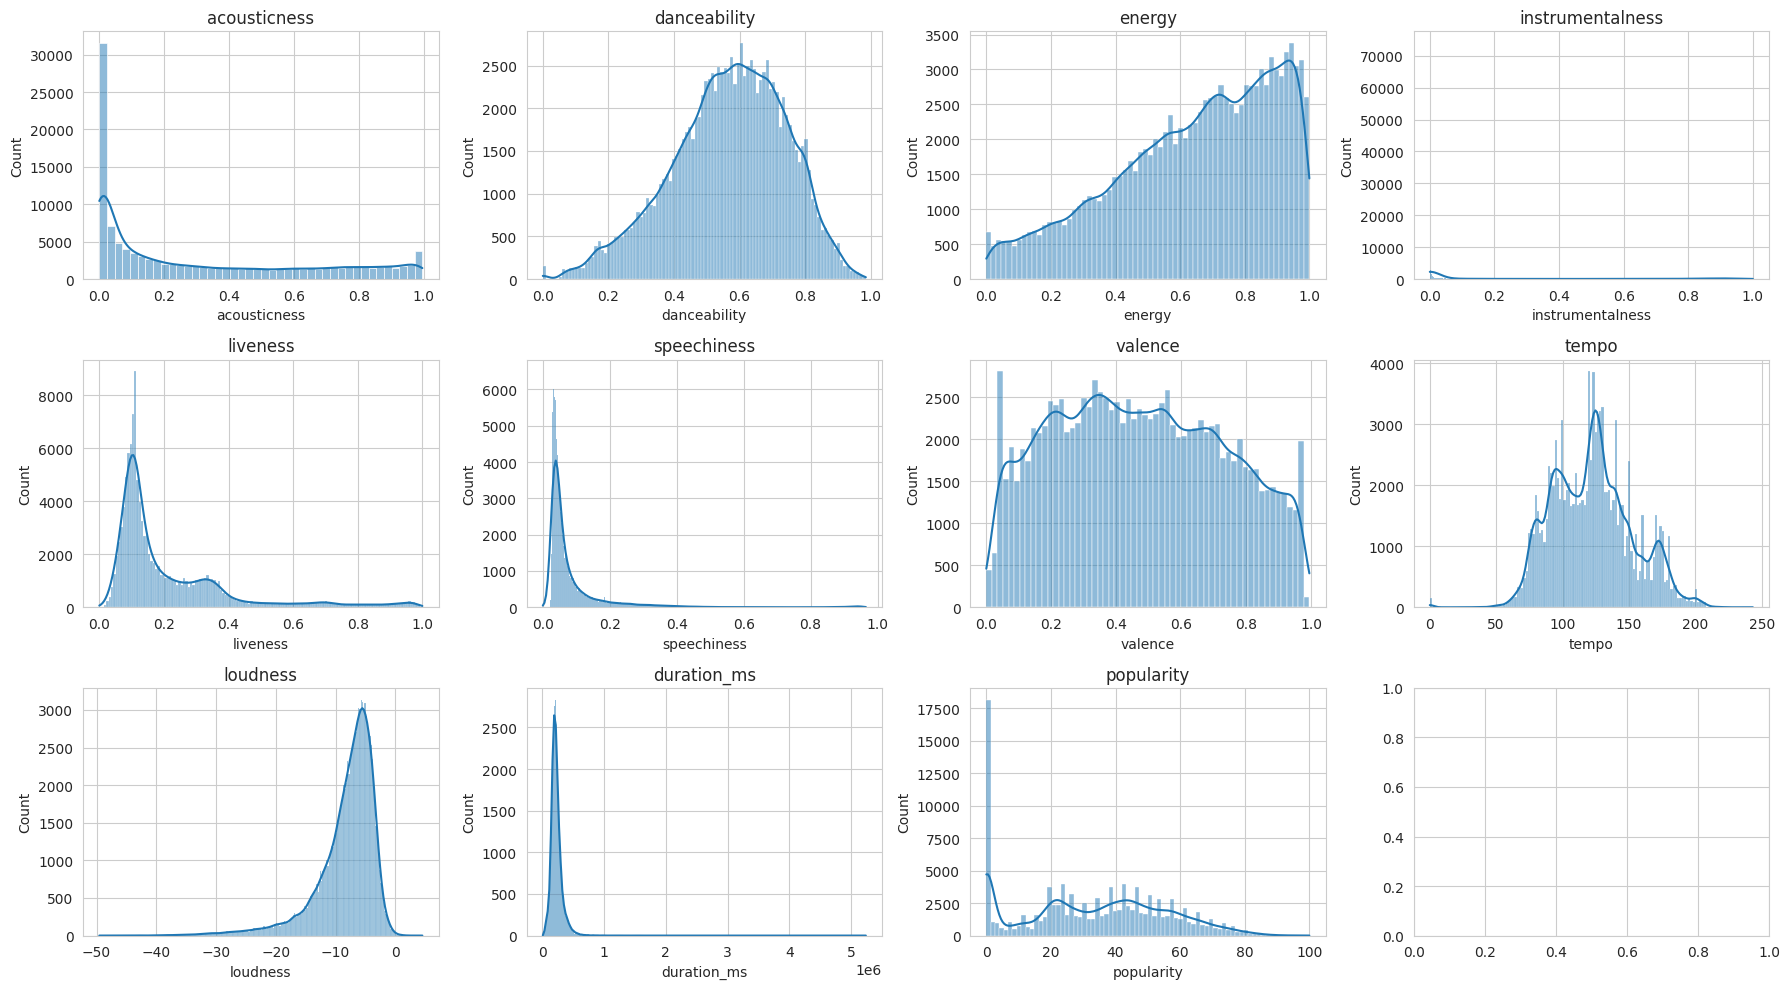

In [ ]:
# STEP 4a ▸ histograms in a loop
fig, axes = plt.subplots(3,4, figsize=(18,10))
axes = axes.flatten()
for i,col in enumerate(feature_cols):
    sns.histplot(tracks[col], ax=axes[i], kde=True)
    axes[i].set_title(col)
plt.tight_layout()

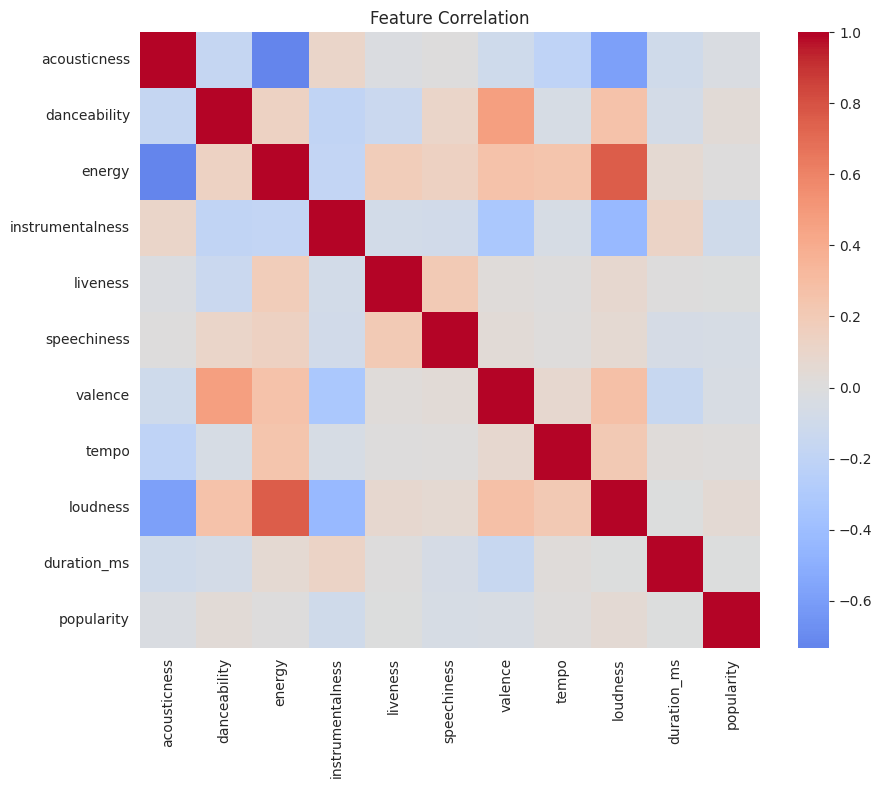

In [ ]:
# step 4b, correlation matrix (heatmap)
corr = tracks[feature_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Feature Correlation")
plt.show()

In [ ]:
# step 5, winsorise via IQR
def cap_outliers(s, k=1.5):
    q1, q3 = np.percentile(s, [25,75])
    iqr   = q3 - q1
    lower = q1 - k*iqr
    upper = q3 + k*iqr
    return np.clip(s, lower, upper)

X_capped = X.apply(cap_outliers)

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_capped)

In [ ]:
#step 7 selecting the optimal number of clusters (elbow and silhouette analysis)

from sklearn.metrics import silhouette_score

k_range = range(2, 11)
inertias, sil_scores = [], []

for k in k_range:
    kmeans  = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    labels  = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)

# as I lack the RAM for the whole dataset, sample points for silhouette. It also makes it faster
# you can cahnge sample size to be larger or smaller depending on system.
    n_total       = X_scaled.shape[0]
    sample_size   = min(10_000, n_total)      # tweak this number if needed. More data is better.
    sil           = silhouette_score(
                        X_scaled, labels,
                        metric="euclidean",
                        sample_size=sample_size,
                        random_state=RANDOM_STATE
                    )
    sil_scores.append(sil)



In [ ]:
# step 8, comparing different models (KMeans, Agglomerative, DBSCAN)
# you can change "TRAIN_SIZE", "EVAL_SIZE", and "DBSCAN_EPS"

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics  import silhouette_score
import numpy as np, pandas as pd, gc

# Here you configure the data size and values for model. Self explanatory.
TRAIN_SIZE   = 10_000
EVAL_SIZE    = 5_000         # this is rows used for silhouette_score
best_k       = 5             # just reuse the K here
DBSCAN_EPS   = 1.3
RANDOM_STATE = 42

#subsample, dont change anything here
rng        = np.random.RandomState(RANDOM_STATE)
take       = rng.choice(X_scaled.shape[0], size=TRAIN_SIZE, replace=False)
X_train    = X_scaled[take]
tracks_sub = tracks.iloc[take].copy().reset_index(drop=True)

# defining models. The 3 we use are KMeans, Agglomerative, DBSCAN.
models = {
    "KMeans": KMeans(n_clusters=best_k, random_state=RANDOM_STATE),
    "Agglomerative": AgglomerativeClustering(
                         n_clusters=best_k, linkage="ward"),
    "DBSCAN": DBSCAN(eps=DBSCAN_EPS, min_samples=10)
}

# fit models
cluster_results = {}

for name, model in models.items():
    labels = model.fit_predict(X_train)
    tracks_sub[f"{name}_label"] = labels            # keep labels

    # this is for DBSCAN, making it skip the noise data
    mask = labels != -1
    if not mask.any():
        cluster_results[name] = np.nan
        continue

    #this is for silhouette score, which is what ill use to compare data
    score = silhouette_score(
                X_train[mask],
                labels[mask],
                sample_size=min(EVAL_SIZE, mask.sum()),
                random_state=RANDOM_STATE,
            )
    cluster_results[name] = score
    print(f"{name:<15}  silhouette = {score:6.3f}")

    # free memory before next iteration
    del labels; gc.collect()



KMeans           silhouette =  0.123
Agglomerative    silhouette =  0.101
DBSCAN           silhouette = -0.083


In [ ]:
# step 9, fit kmeans on all rows and attach any labels.
#I found that minibatchkmeans uses less ram, so I used this instead. Not needed if you have more ram

# Sources
# https://box-world.tistory.com/62
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html

from sklearn.cluster import MiniBatchKMeans


final_k   = best_k                 # pulling k val from before. If this doesnt run, its cause u didnt run the cell before
kmb       = MiniBatchKMeans(n_clusters=final_k,
                            batch_size=4096,  #Apparently setting the batch size to the same as byte counting is faster, so we use 4096.
                            random_state=RANDOM_STATE)
tracks["KMeans_label"] = kmb.fit_predict(X_scaled)   # FULL dataset
tracks["cluster"]      = tracks["KMeans_label"]      # name

print("K-means fitted") #Print at the end to let us know it ran. Unessecary.

K-means fitted


In [ ]:
# THis if for step 10
#Current spotify track id's might not work, as the dataset is multiple years old.
# basically, this recommender wont work for new spotify data, as the track id might not be in the database.
# Only for testing reasons, we can load the first few songs and it's track id to use in step 10.
tracks[['track_name', 'artists', 'track_id']].head(10)

,track_name,artists,track_id
0,Comedy,Gen Hoshino,5SuOikwiRyPMVoIQDJUgSV
1,Ghost - Acoustic,Ben Woodward,4qPNDBW1i3p13qLCt0Ki3A
2,To Begin Again,Ingrid Michaelson;ZAYN,1iJBSr7s7jYXzM8EGcbK5b
3,Can't Help Falling In Love,Kina Grannis,6lfxq3CG4xtTiEg7opyCyx
4,Hold On,Chord Overstreet,5vjLSffimiIP26QG5WcN2K
5,Days I Will Remember,Tyrone Wells,01MVOl9KtVTNfFiBU9I7dc
6,Say Something,A Great Big World;Christina Aguilera,6Vc5wAMmXdKIAM7WUoEb7N
7,I'm Yours,Jason Mraz,1EzrEOXmMH3G43AXT1y7pA
8,Lucky,Jason Mraz;Colbie Caillat,0IktbUcnAGrvD03AWnz3Q8
9,Hunger,Ross Copperman,7k9GuJYLp2AzqokyEdwEw2


In [ ]:
# step 10 interactive recommender

#READ BEFORE RUNNING: get a track id of a specific song you like before running the code. you'll need it as a response.

def get_recs(fav_ids, n_recs=10, seed=RANDOM_STATE):

    # fav_ids can be spotify track IDs or integer DataFrame indices.

    # allow either indexing method. We are basically building a Boolean mask of the favourites in our DataFrame
    fav_mask = tracks["track_id"].isin(fav_ids) | tracks.index.astype(str).isin(fav_ids)
    fav_clusters = tracks.loc[fav_mask, "cluster"] #This line finds which clusters those favourites belong to


    if fav_clusters.empty:
        raise ValueError("None of the provided IDs matched the data.")

    # majority vote, listener's dominant cluster
    target_cluster = fav_clusters.value_counts().idxmax()

# these 3 lines:
# they grab every song in that cluster,
# excludes what the listener already likes,
# and randomly picks n recommendations. You can change how many recs in the CLI demo part
    candidates = tracks[tracks["cluster"] == target_cluster]
    candidates = candidates[~candidates["track_id"].isin(fav_ids)]   # don’t recommend songs you already love
    return candidates.sample(n=min(n_recs, len(candidates)),
                             random_state=seed)

#ClI demo
raw = input("Enter Track IDs or row numbers (comma-sep):\n> ")
fav_ids = [x.strip() for x in raw.split(",") if x.strip()]
recs = get_recs(fav_ids, n_recs=5)
display(recs[["track_name", "artists", "popularity"]])

Enter Track IDs or row numbers (comma-sep):
> 12


,track_name,artists,popularity
51243,Kannala Kannala - The Melting Point of Love,Hiphop Tamizha;Kaushik Krish;Padmalatha,63
96181,É Tudo - Ao Vivo,Caju Pra Baixo;Belo,43
18135,Sodium Erythortbate,Kyle Kinane,26
105702,Black Foam,Skinny Cap,33
8366,Wild Child,The Black Keys,69


In [ ]:
# step 11:
# this is a feedback loop. The user should listen to the recommended songs prior to running this code.
# This is also dependent on you running step 10,
if "recs" not in globals():
    raise RuntimeError("run step 10 first bro") #if u dont run step 10 first ull get this error

#The system asks the user to rate the songs from 1-5
feedback_rows = []
for _, row in recs.iterrows():
    print(f"\n▶  {row.track_name}  – {row.artists}")
    rating = input("Rate 1–5 (or ENTER to skip): ") #input line here, the user shoudl rate songs between 1-5. you can also use scanner.sc library for this instead if it doesnt work.
    if rating.strip():
        feedback_rows.append({"track_id": row.track_id,
                              "liked": int(rating)})
#runs an if statement to create a NEW csv file. Basically all the code does is it stores your responses in a csv file.
# this might not seem like a very helpful feedback system but it will help if we want to develop this code further.
if feedback_rows:
    (pd.DataFrame(feedback_rows)
       .to_csv("user_feedback.csv",
               mode="a",
               header=not os.path.exists("user_feedback.csv"),
               index=False))
    print("✓  Feedback stored")
else:
    print("No feedback entered")


▶  Kannala Kannala - The Melting Point of Love  – Hiphop Tamizha;Kaushik Krish;Padmalatha
Rate 1–5 (or ENTER to skip): 

▶  É Tudo - Ao Vivo  – Caju Pra Baixo;Belo
Rate 1–5 (or ENTER to skip): 

▶  Sodium Erythortbate  – Kyle Kinane
Rate 1–5 (or ENTER to skip): 

▶  Black Foam  – Skinny Cap
Rate 1–5 (or ENTER to skip): 3

▶  Wild Child  – The Black Keys
Rate 1–5 (or ENTER to skip): 2
✓  Feedback stored


# Innovation!
To make our project more innovative, we decided to implement a feature that allows users to pick their mood. In Spotify's API is something called Valence, that describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (happy, cheerful, euphoric), while tracks with low valence sound more negative (sad, depressed, angry).

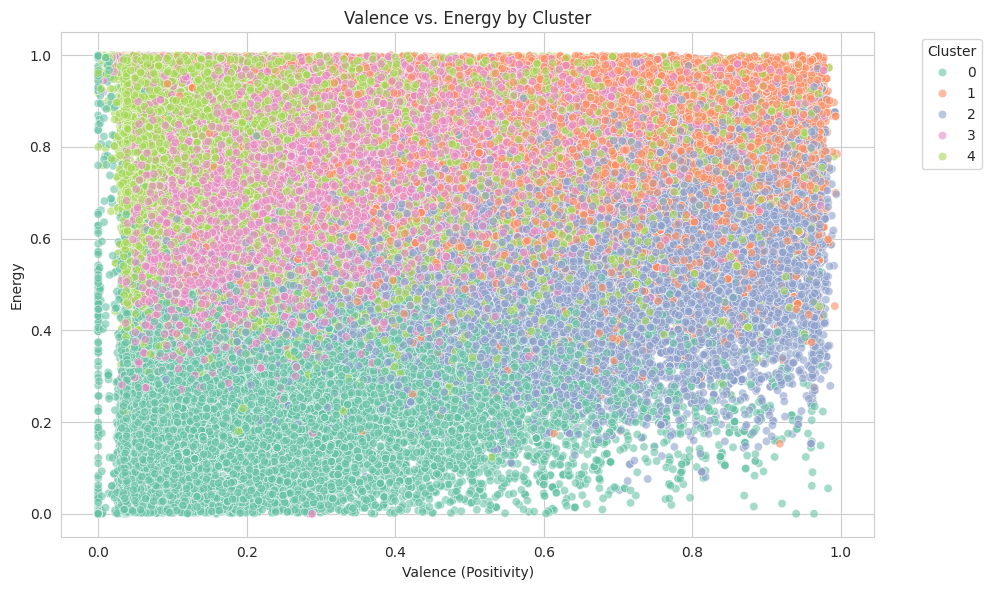

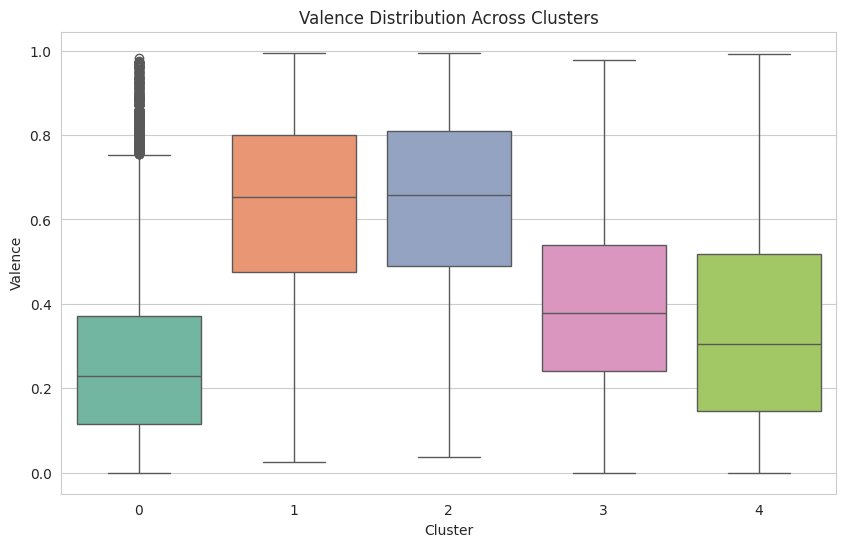


we added a basic feedback loop that lets users rate songs from 1 to 5.
ratings are saved in a 'user_feedback.csv' file.
This creates a starting point for future model updates based on user preferences.



In [ ]:
# STEP 12

# scatterplot
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=tracks,
    x="valence",
    y="energy",
    hue="cluster",
    palette="Set2",
    alpha=0.6
)
plt.title("Valence vs. Energy by Cluster")
plt.xlabel("Valence (Positivity)")
plt.ylabel("Energy")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# valence distribution per cluster
plt.figure(figsize=(10,6))
sns.boxplot(data=tracks, x="cluster", y="valence", palette="Set2")
plt.title("Valence Distribution Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Valence")
plt.show()

# user feedback system
print("""
we added a basic feedback loop that lets users rate songs from 1 to 5.
ratings are saved in a 'user_feedback.csv' file.
This creates a starting point for future model updates based on user preferences.
""")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from collections import deque


path = "spotify_tracks.csv"
tracks_raw = pd.read_csv(path)


tracks_raw.info()
print(tracks_raw.isna().sum())


tracks = tracks_raw.dropna(subset=["artists", "track_name"]).reset_index(drop=True)


feature_cols = [
    "acousticness", "danceability", "energy", "instrumentalness",
    "liveness", "speechiness", "valence", "tempo",
    "loudness", "duration_ms", "popularity"
]


songs_df = tracks[['track_id', 'track_name', 'artists'] + feature_cols].copy()


song_vectors = songs_df[feature_cols].values

user_profile = np.zeros(len(feature_cols))
recent_plays = deque(maxlen=5)



def play_song(track_id):
    global user_profile

    song_row = songs_df[songs_df['track_id'] == track_id]
    if song_row.empty:
        print(f"Track ID {track_id} not found in the dataset.")
        return

    title = song_row['track_name'].values[0]
    artists = song_row['artists'].values[0]
    vector = song_row[feature_cols].values[0]

    print(f" User played: {title} by {artists}")

    recent_plays.append(track_id)

    recent_vectors = [songs_df[songs_df['track_id'] == tid][feature_cols].values[0] for tid in recent_plays if tid in songs_df['track_id'].values]
    if recent_vectors:
        user_profile = np.mean(recent_vectors, axis=0)
    else:
        user_profile = np.zeros(len(feature_cols))


    recommend()


def recommend(top_k=5):
    if user_profile.sum() == 0:
        print("Play some songs first to get recommendations.")
        return


    sim_scores = cosine_similarity([user_profile], song_vectors)[0]


    recommended_indices = []
    for idx in np.argsort(sim_scores)[::-1]:
        track_id = songs_df.iloc[idx]['track_id']
        if track_id not in recent_plays:
            recommended_indices.append(idx)
        if len(recommended_indices) >= top_k:
            break

    print(" Recommended for you:")
    if not recommended_indices:
        print(" No recommendations found.")
    else:
        for idx in recommended_indices:
            song_title = songs_df.iloc[idx]['track_name']
            song_artists = songs_df.iloc[idx]['artists']
            print(f"  → {song_title} by {song_artists} (similarity: {sim_scores[idx]:.2f})")



if __name__ == "__main__":
    #
    play_song('6Vc5wAMmXdKIAM7WUoEb7N') # Say Something by A Great Big World;Christina Aguilera
    play_song('5vjLSffimiIP26QG5WcN2K') # Hold On by Chord Overstreet
    play_song('1iJBSr7s7jYXzM8EGcbK5b') # To Begin Again by Ingrid Michaelson;ZAYN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11